In [1]:
import pandas as pd
import numpy as np
import mysql.connector
from scipy import stats
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
def mysql_query(query_str):
    cnx  = mysql.connector.connect(user='student', password='password', host='104.131.127.158', database='stats')
    df = pd.read_sql(query_str, con=cnx)
    cnx.close()
    return df

In [3]:
def plot_corr(df, col1, col2, title, rx, ry):
    x = df[col1]
    y = df[col2]
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    rsqr = r_value**2

    fig, ax = plt.subplots()
    df[[col1,col2]].plot(kind='scatter', x=col1, y=col2, 
                                                           title=title, ax=ax)
    ax.plot(x, intercept+(slope*x))
    ax.text(rx, ry, '$R^2 = %0.4f$'%rsqr, fontsize=20)

In [4]:
yoy_comparison = mysql_query("select p1.playerID as playerID, p1.yearID as yearID, p1.IPouts, p1.ER, p1.HR, "
                             "p1.BB, p1.HBP, p1.SO, p2.playerID as playerID_2, cast(p2.yearID as unsigned) as yearID_2, "
            "p2.IPouts as IPouts_2, p2.ER as ER_2, p2.HR as HR_2, p2.BB as BB_2, p2.HBP as HBP_2, p2.SO as SO_2 from "
                "(select playerID, yearID, sum(ER) as ER, sum(HR) as HR, sum(BB) as BB, sum(HBP) as HBP, "
                "sum(SO) as SO, sum(IPouts) as IPouts FROM stats.pitching sp "
                "where yearID>1995 group by playerID, yearID having sum(IPouts)>483) p1 "                             
            "left join "
            "(select playerID, yearID, sum(ER) as ER, sum(HR) as HR, sum(BB) as BB, sum(HBP) as HBP, "
                "sum(SO) as SO, sum(IPouts) as IPouts FROM stats.pitching sp "
                "where yearID>1995 group by playerID, yearID having sum(IPouts)>483) p2 " 
                "on p1.yearID+1=p2.yearID and p1.playerID=p2.playerID;")

In [5]:
yoy_comparison = yoy_comparison.dropna().reset_index(drop=True)
yoy_comparison['yearID_2'] = yoy_comparison['yearID_2'].astype(int)

In [7]:
fip_constant = pd.read_csv('historical_constant.csv', 
                          usecols=["Season",'cFIP'])
fip_constant.columns = ['yearID', 'cFIP']

In [8]:
yoy_comparison['cfip'] = pd.merge(yoy_comparison[['yearID']], fip_constant, on='yearID',how='left')['cFIP']
yoy_comparison['cfip_2'] = pd.merge(yoy_comparison[['yearID_2']], fip_constant, left_on='yearID_2', right_on='yearID',how='left')['cFIP']

In [9]:
yoy_comparison['era_year_1'] = yoy_comparison.apply(lambda row: 9*(row['ER']/(row['IPouts']/3)), axis=1)
yoy_comparison['era_year_2'] = yoy_comparison.apply(lambda row: 9*(row['ER_2']/(row['IPouts_2']/3)), axis=1)

In [10]:
yoy_comparison.head()

,playerID,yearID,IPouts,ER,HR,BB,HBP,SO,playerID_2,yearID_2,IPouts_2,ER_2,HR_2,BB_2,HBP_2,SO_2,cfip,cfip_2,era_year_1,era_year_2
0,abbotpa01,2000,537.0,84.0,23.0,80.0,5.0,100.0,abbotpa01,2001,489.0,77.0,21.0,87.0,7.0,118.0,3.134,3.049,4.223464,4.251534
1,alvarwi01,1996,652.0,102.0,21.0,97.0,4.0,181.0,alvarwi01,1997,636.0,82.0,18.0,91.0,4.0,179.0,3.172,3.109,4.223926,3.481132
2,anderbr02,2003,593.0,83.0,27.0,43.0,4.0,87.0,anderbr02,2004,498.0,104.0,33.0,53.0,1.0,70.0,3.031,3.049,3.779089,5.638554
3,appieke01,1996,634.0,85.0,17.0,75.0,5.0,207.0,appieke01,1997,707.0,89.0,24.0,74.0,4.0,196.0,3.172,3.109,3.619874,3.398868
4,appieke01,1999,627.0,120.0,27.0,84.0,7.0,131.0,appieke01,2000,586.0,98.0,23.0,102.0,9.0,129.0,3.134,3.134,5.167464,4.515358


In [11]:
'((13*HR)+(3*(BB+HBP))-(2*K))/IP + constant'

'((13*HR)+(3*(BB+HBP))-(2*K))/IP + constant'

In [12]:
yoy_comparison['fip_year_1'] = yoy_comparison.apply(lambda row: ((13*row['HR'])+(3*(row['BB']+row['HBP']))-(2*row['SO']))/(row['IPouts']/3)+row['cfip'], axis=1)
yoy_comparison['fip_year_2'] = yoy_comparison.apply(lambda row: ((13*row['HR_2'])+(3*(row['BB_2']+row['HBP_2']))-(2*row['SO_2']))/(row['IPouts_2']/3)+row['cfip_2'], axis=1)

In [13]:
yoy_comparison.head()

,playerID,yearID,IPouts,ER,HR,BB,HBP,SO,playerID_2,yearID_2,...,HR_2,BB_2,HBP_2,SO_2,cfip,cfip_2,era_year_1,era_year_2,fip_year_1,fip_year_2
0,abbotpa01,2000,537.0,84.0,23.0,80.0,5.0,100.0,abbotpa01,2001,...,21.0,87.0,7.0,118.0,3.134,3.049,4.223464,4.251534,5.111654,5.006055
1,alvarwi01,1996,652.0,102.0,21.0,97.0,4.0,181.0,alvarwi01,1997,...,18.0,91.0,4.0,179.0,3.172,3.109,4.223926,3.481132,4.156663,3.868434
2,anderbr02,2003,593.0,83.0,27.0,43.0,4.0,87.0,anderbr02,2004,...,33.0,53.0,1.0,70.0,3.031,3.049,3.779089,5.638554,4.639769,5.765867
3,appieke01,1996,634.0,85.0,17.0,75.0,5.0,207.0,appieke01,1997,...,24.0,74.0,4.0,196.0,3.172,3.109,3.619874,3.398868,3.394397,3.762465
4,appieke01,1999,627.0,120.0,27.0,84.0,7.0,131.0,appieke01,2000,...,23.0,102.0,9.0,129.0,3.134,3.134,5.167464,4.515358,4.866057,5.048676


Text(5,1.5,'$R^2 = 0.18$')

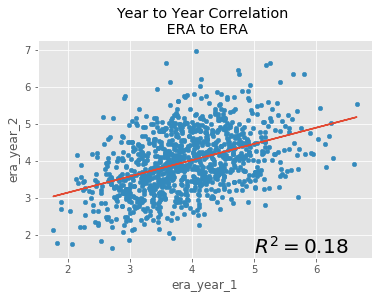

In [14]:
x = yoy_comparison['era_year_1']
y = yoy_comparison['era_year_2']
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
rsqr = r_value**2

fig, ax = plt.subplots()
yoy_comparison[['era_year_1','era_year_2']].plot(kind='scatter', x='era_year_1', y='era_year_2', 
                                                       title='Year to Year Correlation \n ERA to ERA', ax=ax)
ax.plot(x, intercept+(slope*x))
ax.text(5, 1.5, '$R^2 = %0.2f$'%rsqr, fontsize=20)

Text(5,1.5,'$R^2 = 0.24$')

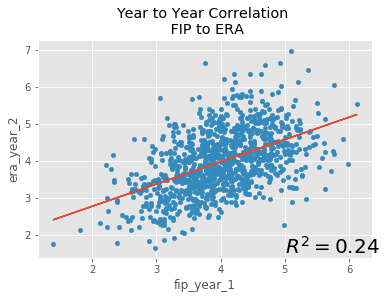

In [15]:
x = yoy_comparison['fip_year_1']
y = yoy_comparison['era_year_2']
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
rsqr = r_value**2

fig, ax = plt.subplots()
yoy_comparison[['fip_year_1','era_year_2']].plot(kind='scatter', x='fip_year_1', y='era_year_2', 
                                                       title='Year to Year Correlation \n FIP to ERA', ax=ax)
ax.plot(x, intercept+(slope*x))
ax.text(5, 1.5, '$R^2 = %0.2f$'%rsqr, fontsize=20)

## xFIP and SIERA predict next year ERA better than FIP

## Team Wins Predicted by Runs - Pythagorean

In [16]:
team_perf = mysql_query('select yearID, teamID, R, RA, W, L from teams where yearID>1995;')
team_perf['W_PCT'] = team_perf.apply(lambda row: row['W']/float((row['W']+row['L'])), axis=1)

In [17]:
team_perf.sort_values(['yearID','W_PCT'], ascending=[1,0]).tail(30)

,yearID,teamID,R,RA,W,L,W_PCT
581,2015,SLN,647,525,100,62,0.617284
582,2015,PIT,697,596,98,64,0.604938
583,2015,CHN,689,608,97,65,0.598765
566,2015,KCA,724,641,95,67,0.586420
571,2015,TOR,891,670,93,69,0.574074
591,2015,LAN,667,595,92,70,0.567901
586,2015,NYN,683,613,90,72,0.555556
576,2015,TEX,751,733,88,74,0.543210
572,2015,NYA,764,698,87,75,0.537037
577,2015,HOU,729,618,86,76,0.530864


## Calculate Pythag
W%=[(Runs Scored)^2]/[(Runs Scored)^2 + (Runs Allowed)^2]

In [18]:
team_perf['PYTHAG'] = team_perf.apply(lambda row: (row['R']**2)/float((row['R']**2)+(row['RA']**2)), axis=1)

Text(0.6,0.3,'$R^2 = 0.8808$')

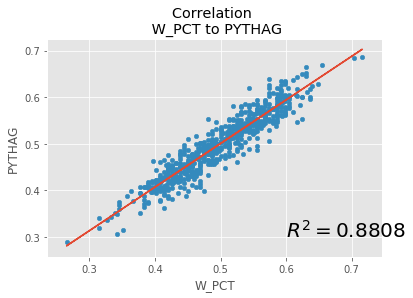

In [19]:
x = team_perf['W_PCT']
y = team_perf['PYTHAG']
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
rsqr = r_value**2

fig, ax = plt.subplots()
team_perf[['W_PCT','PYTHAG']].plot(kind='scatter', x='W_PCT', y='PYTHAG', 
                                                       title='Correlation \n W_PCT to PYTHAG', ax=ax)
ax.plot(x, intercept+(slope*x))
ax.text(.6, .3, '$R^2 = %0.4f$'%rsqr, fontsize=20)

## Calculate Pythagenpat
((rs + ra)/g)^.285

In [20]:
pythag_lookup = mysql_query('select yearID, POW(Round((sum(R)+sum(RA))/sum(G),4),0.287) as PYPAT_EXP from teams where yearID>1995 group by yearID;')

In [21]:
pythag_lookup

,yearID,PYPAT_EXP
0,1996,1.940358
1,1997,1.910082
2,1998,1.912688
3,1999,1.945775
4,2000,1.951852
5,2001,1.911047
6,2002,1.892788
7,2003,1.905584
8,2004,1.915451
9,2005,1.889659


In [22]:
team_perf['PYPAT_EXP'] = pd.merge(team_perf, pythag_lookup, on='yearID', how='left')['PYPAT_EXP']

In [23]:
team_perf['PYTHAGENPAT'] = team_perf.apply(lambda row: (row['R']**row['PYPAT_EXP'])/float((row['R']**row['PYPAT_EXP'])+(row['RA']**row['PYPAT_EXP'])), axis=1)

Text(0.6,0.3,'$R^2 = 0.8815$')

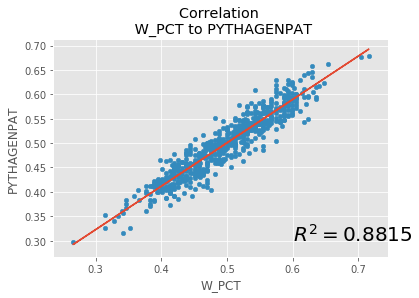

In [24]:
x = team_perf['W_PCT']
y = team_perf['PYTHAGENPAT']
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
rsqr = r_value**2

fig, ax = plt.subplots()
team_perf[['W_PCT','PYTHAGENPAT']].plot(kind='scatter', x='W_PCT', y='PYTHAGENPAT', 
                                                       title='Correlation \n W_PCT to PYTHAGENPAT', ax=ax)
ax.plot(x, intercept+(slope*x))
ax.text(.6, .3, '$R^2 = %0.4f$'%rsqr, fontsize=20)

## Hitting Statistics ability to Predict Runs

In [25]:
team_bat = mysql_query('select teamID, yearID, R, H, BB, HBP, AB, SF, 2B, 3B, HR  from teams where yearID>1999;')
team_bat['HBP'] = team_bat['HBP'].astype('int')
team_bat['SF'] = team_bat['SF'].astype('int')

In [26]:
team_bat['batting_average'] = team_bat['H'] / team_bat['AB']

In [27]:
team_bat.head()

,teamID,yearID,R,H,BB,HBP,AB,SF,2B,3B,HR,batting_average
0,ANA,2000,864,1574,608,47,5628,43,309,34,236,0.279673
1,ARI,2000,792,1466,535,59,5527,58,282,44,179,0.265243
2,ATL,2000,810,1490,595,59,5489,45,274,26,179,0.271452
3,BAL,2000,794,1508,558,49,5549,54,310,22,184,0.271761
4,BOS,2000,792,1503,611,42,5630,48,316,32,167,0.266963


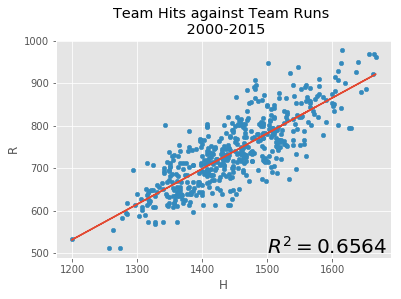

In [28]:
plot_corr(team_bat, 'H', 'R', 'Team Hits against Team Runs \n 2000-2015', 1500, 500)

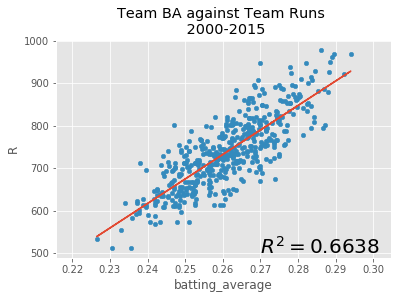

In [29]:
plot_corr(team_bat, 'batting_average', 'R', 'Team BA against Team Runs \n 2000-2015', .27, 500)

## On Base Percentage
$OBP$ = ${\frac  {H+BB+HBP}{AB+BB+HBP+SF}}$

In [30]:
team_bat['on_base_pct'] = team_bat.apply(lambda row: (row['H']+row['BB']+row['HBP']) / float(row['AB']+row['BB']+row['HBP']+row['SF']), axis=1)

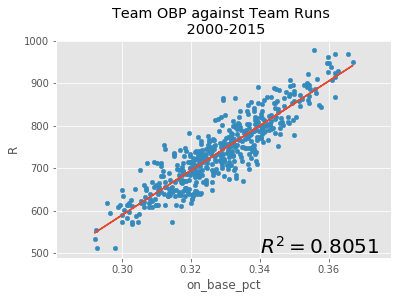

In [31]:
plot_corr(team_bat, 'on_base_pct', 'R', 'Team OBP against Team Runs \n 2000-2015', .340, 500)

## Slugging Percentage
${\displaystyle \mathrm {SLG} ={\frac {({\mathit {1B}})+(2\times {\mathit {2B}})+(3\times {\mathit {3B}})+(4\times {\mathit {HR}})}{AB}}}$

In [32]:
team_bat['1B'] = team_bat['H'] - (team_bat['2B']+team_bat['3B']+team_bat['HR'])

In [33]:
team_bat['slg_pct'] = (team_bat['1B'] + (2*team_bat['2B'])+ (3*team_bat['3B']) +(4*team_bat['HR']))/team_bat['AB']

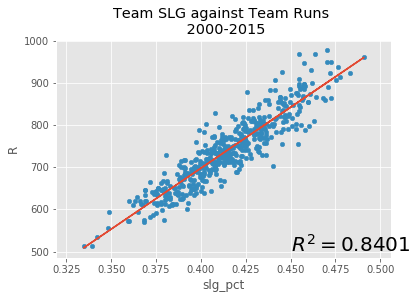

In [34]:
plot_corr(team_bat, 'slg_pct', 'R', 'Team SLG against Team Runs \n 2000-2015', .45, 500)

## On Base plus Slugging (OPS)
$OPS=OBP+SLG$

In [35]:
team_bat['ops'] = team_bat['on_base_pct'] + team_bat['slg_pct']

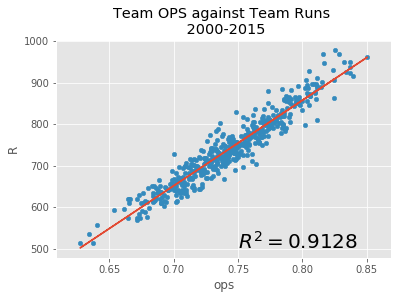

In [36]:
plot_corr(team_bat, 'ops', 'R', 'Team OPS against Team Runs \n 2000-2015', .75, 500)

## Weighted On Base Average (wOBA)
$wOBA=\frac{(0.69*BB) + (0.72*HBP) + (0.89*\mathit{1}B) + (1.27*\mathit{2}B) + (1.62*\mathit{3}B) + (2.10*HR)}{PA}$

In [37]:
team_bat['woba'] = team_bat.apply(lambda row: ((.69*row['BB'])+(.72*row['HBP'])+(.89*row['1B'])+(1.27*row['2B'])+(1.62*row['3B'])+(2.10*row['HR']))/(row['AB']+row['BB']+row['HBP']), axis=1)

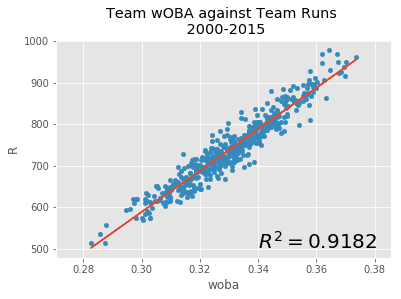

In [38]:
plot_corr(team_bat, 'woba', 'R', 'Team wOBA against Team Runs \n 2000-2015', .340, 500)